<a href="https://colab.research.google.com/github/heewonLEE2/Data-Ai-Colab/blob/main/Inference_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **그림판으로 숫자를 그려 모델이 잘 맞추는지 테스트 해보기!**: ✅

## 모델 클래스 & 체크포인트 로드

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch.nn as nn
import torch.nn.functional as F
import os, math

# 디바이스
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 시 사용했던 동일 구조
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 28->14

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 14->7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)

# 학습 때 저장한 가중치 로드
ckpt_path = "/content/best_model.pt"   # 경로 맞게 조정
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.eval()
print("모델/장치:", next(model.parameters()).device)

모델/장치: cpu


## 전처리 함수: (RGB→Grayscale, 자동 반전, 타이트 크롭, 20x20 리사이즈+패딩, 정규화)

In [2]:
import numpy as np
from scipy import ndimage

MEAN, STD = 0.1307, 0.3081  # 학습 시 사용한 MNIST 정규화

def preprocess_digit(img_path, invert='auto', show=True):
    """
    img_path: 업로드한 그림판 이미지 경로 (png/jpg 등)
    invert: 'auto' | True | False
      - MNIST는 '검은 배경 + 흰 숫자' 형태. 그림판이 '흰 배경 + 검은 숫자'면 자동 반전 필요.
    """
    # 1) 로드 & 그레이스케일
    img = Image.open(img_path).convert('L')  # 0=black ~ 255=white

    # 2) (옵션) 자동 반전: 배경이 밝으면 반전하여 배경을 어둡게, 숫자를 밝게
    arr = np.array(img)
    if invert == 'auto':
        if arr.mean() > 127:  # 평균이 밝으면 (흰 배경일 확률 ↑)
            img = ImageOps.invert(img)
            arr = np.array(img)
    elif invert is True:
        img = ImageOps.invert(img)
        arr = np.array(img)

    # 3) 타이트 크롭: 숫자 있는 영역만 bounding box로 잘라내기
    #    약한 임계처리로 숫자 픽셀 감지
    mask = arr > 20  # 아주 어두운 배경 제거
    if mask.any():
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        img = img.crop((x0, y0, x1, y1))
    else:
        # 모든 픽셀이 거의 배경이라면 그대로 진행
        pass

    # 4) 20x20에 맞춰 비율 유지 리사이즈
    #    (MNIST 전처리 관례: 20x20에 숫자를 맞추고 주변 4픽셀 패딩 → 28x28)
    img = np.array(img)
    h, w = img.shape
    if h == 0 or w == 0:
        raise ValueError("비어있는 이미지로 감지됨.")
    # 더 긴 변을 20으로 스케일
    if h > w:
        new_h, new_w = 20, max(1, int(round(20 * w / h)))
    else:
        new_w, new_h = 20, max(1, int(round(20 * h / w)))
    img = Image.fromarray(img).resize((new_w, new_h), Image.BILINEAR)

    # 5) 28x28 패딩(가운데 배치)
    canvas = Image.new('L', (28, 28), color=0)
    left = (28 - new_w) // 2
    top  = (28 - new_h) // 2
    canvas.paste(img, (left, top))
    img = np.array(canvas).astype(np.float32)

    # 6) 중심 이동(선택): 질량중심을 캔버스 중앙에 맞추기 → 인식률 안정화
    #    (흔한 테크닉. 필요 없으면 이 블록을 주석 처리해도 됨.)
    def center_of_mass_shift(a):
        a_norm = a / 255.0
        cy, cx = ndimage.center_of_mass(a_norm)
        if np.isnan(cx) or np.isnan(cy):
            return a  # 빈 이미지면 스킵
        shift_x = int(round(14 - cx))
        shift_y = int(round(14 - cy))
        return ndimage.shift(a, shift=(shift_y, shift_x), mode='constant', cval=0.0)
    img = center_of_mass_shift(img)

    # 7) [0,1] → 정규화 → 텐서화 (1,1,28,28)
    img = img / 255.0
    img = (img - MEAN) / STD
    tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(torch.float32)

    if show:
        plt.figure(figsize=(3,3))
        plt.imshow(((img*STD)+MEAN), cmap='gray')  # 역정규화로 보기 좋게
        plt.title("Preprocessed 28x28")
        plt.axis('off'); plt.show()

    return tensor

## 추론 함수 + 상위 확률 출력(Top-k)

['demo_inputs/my_image.png', 5, 0.9999947547912598]
['demo_inputs/my_image2.png', 8, 0.99992835521698]
['demo_inputs/my_image3.png', 9, 0.9999547004699707]
['demo_inputs/my_image4.png', 4, 0.9991607666015625]
Saved: results/demo/batch_preds.csv


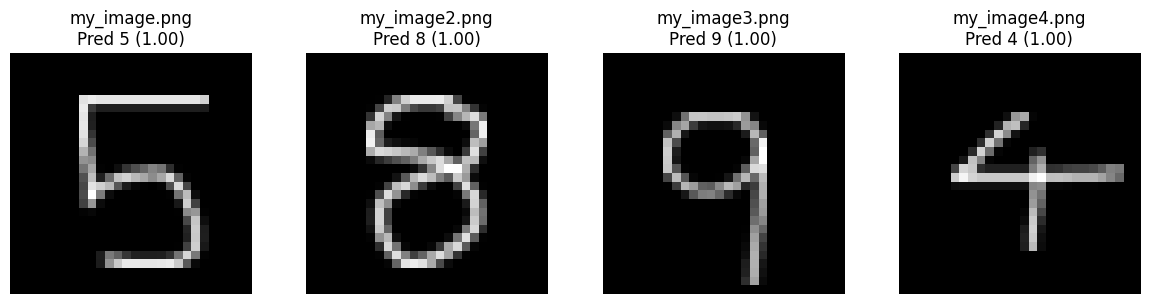

Saved: results/demo/batch_grid.png


In [6]:
from glob import glob
import os, csv, numpy as np, matplotlib.pyplot as plt
import torch.nn.functional as F

os.makedirs("results/demo", exist_ok=True)

# 1) 입력 수집
paths = sorted(glob("demo_inputs/*.png"))  # 상대경로 권장
assert paths, "demo_inputs 폴더에 *.png를 넣어주세요."

# 2) 배치 추론
rows, imgs = [], []
for p in paths:
    try:
        x = preprocess_digit(p, invert='auto', show=False).to(device)
        with torch.no_grad():
            prob = F.softmax(model(x), dim=1).squeeze(0).cpu().numpy()
        pred = int(prob.argmax())
        rows.append([p, pred, float(prob[pred])])
        # 그리드 표시용
        img = x.squeeze().cpu().numpy()
        img = np.clip(img*0.3081 + 0.1307, 0, 1)  # 역정규화
        imgs.append((os.path.basename(p), img, pred, float(prob[pred])))
    except Exception as e:
        rows.append([p, f"ERROR: {e}", ""])

# 3) 콘솔 요약
for r in rows:
    print(r)

# 4) CSV 저장
with open("results/demo/batch_preds.csv", "w", newline="") as f:
    writer = csv.writer(f); writer.writerow(["path","pred","prob"]); writer.writerows(rows)
print("Saved: results/demo/batch_preds.csv")

# 5) 이미지 그리드 저장+표시
if imgs:
    n = len(imgs)
    plt.figure(figsize=(3*n, 3))
    for i, (name, img, pred, prob) in enumerate(imgs, 1):
        plt.subplot(1, n, i); plt.imshow(img, cmap="gray")
        plt.title(f"{name}\nPred {pred} ({prob:.2f})"); plt.axis("off")
    plt.tight_layout(); plt.savefig("results/demo/batch_grid.png", dpi=150); plt.show()
    print("Saved: results/demo/batch_grid.png")
